In [1]:
# I want to be able to import all python .py files in /media/my_ftp/TFTs/amoure/TFM_MUIT/src/cls from this notebook
import sys
import os
import sys
# Get the current notebook's directory path
notebook_dir = os.getcwd()

# Define the directory path of the .py files you want to import
target_dir = os.path.dirname(notebook_dir)
print(target_dir)
# Add the target directory to the sys.path
sys.path.append(target_dir)


/media/my_ftp/TFTs/amoure/TFM_MUIT/src/cls


In [2]:
from data_lightning import ClassificationCovidDataModule

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random


def plot_image_and_histogram(image, label, img_path):
    fig, axs = plt.subplots(2)
    axs[0].imshow(image.permute(1, 2, 0))
    axs[0].set_title(f'Label: {label}, Path: {img_path}')
    axs[1].hist(image.flatten(), bins=256)
    plt.show()

#Plot batch without using the make_grid function to allow for more flexibility
# 
def plot_batch(batched_img_tensor, batched_label_tensor, batched_img_nm, batched_dataset_nm, batched_has_infection, batch_size=16, inverse_transform=False):
    fig, axs = plt.subplots(batch_size, 2, figsize=(20, batch_size*5))
    for i in range(batch_size):
        img = batched_img_tensor[i]
        if inverse_transform:
            img = inverse_transform(img)
        label = batched_label_tensor[i]
        img_nm = batched_img_nm[i]
        dataset_nm = batched_dataset_nm[i]
        has_infection = batched_has_infection[i]
        axs[i, 0].imshow(img.permute(1, 2, 0))
        axs[i, 0].set_title(f'Label: {label}, Path: {img_nm.split("/")[-1]}, Dataset: {dataset_nm}, Infection: {has_infection}')
        axs[i, 1].hist(img.flatten(), bins="auto")
        axs[i, 1].set_title(f'Max: {img.max():.2f}, Min: {img.min():.2f}')
        
    plt.show()


In [6]:
metadata_path = "/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/processed/classification/classification_metadata.pkl"
n_classes = 4
img_size = (224, 224)
batch_size = 32

covid_data_module = ClassificationCovidDataModule(
    metadata_path=metadata_path,
    n_classes=n_classes,
    img_size=img_size,
    batch_size=16,
    debug=True,
    
)

covid_data_module.setup()

train_dataloader = covid_data_module.train_dataloader()
val_dataloader = covid_data_module.val_dataloader()




Mode: train Samples: 354602 Limit: None Classes: 4 debug_fg: True
Mode: val Samples: 88812 Limit: None Classes: 4 debug_fg: True


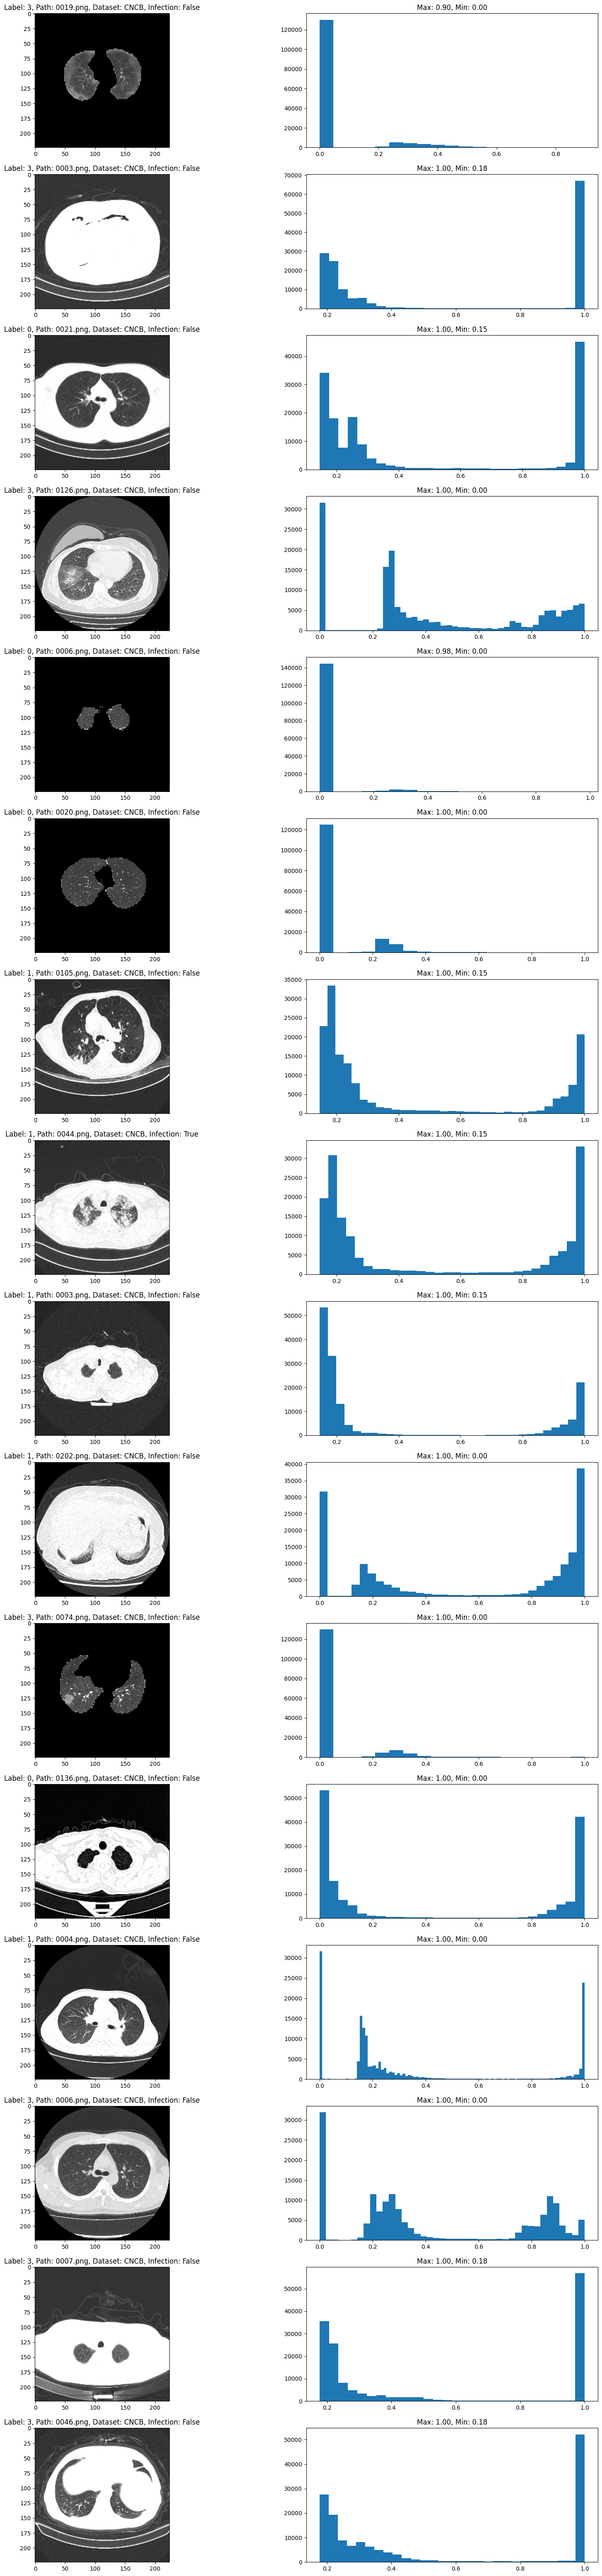

: 

In [8]:
_,  batched_label_tensor, batched_img_tensor, batched_img_nm, batched_dataset_nm, batched_has_infection = next(iter(train_dataloader))
plot_batch(batched_img_tensor, batched_label_tensor, batched_img_nm, batched_dataset_nm,batched_has_infection, batch_size=16)

In [15]:
#define a very simple pytorch model with all needed functions:
import torch
import torch.nn as nn
import torch.nn.functional as F
from bayesian_torch.utils.util import predictive_entropy, mutual_information

n_mc_samples = 10
n_classes = 3
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


#initialize the model
model = SimpleMLP(input_dim=3*224*224, output_dim=n_classes)
# create random input tensor
x = torch.randn(16, 3, 224, 224)
labels_t = torch.randint(0, n_classes, (16,))
# pass the input tensor through the model
output = model(x)
output_mc = []
for _ in range(n_mc_samples):
    logits = model(x)
    probs = torch.nn.functional.softmax(logits, dim=-1)
    output_mc.append(probs)
output = torch.stack(output_mc)
mean_probs = output.mean(dim=0)
predicted_labels = torch.argmax(mean_probs, dim=1)
pred_uncertainty = predictive_entropy(output.data.cpu().numpy())
model_uncertainty = mutual_information(output.data.cpu().numpy())

In [17]:
uncertainty_t = torch.tensor(pred_uncertainty)

In [19]:
uncertainty_t[predicted_labels == labels_t]

tensor([1.0967, 1.0959, 1.0966])